<a href="https://colab.research.google.com/github/ricmoccia/progetto-machine-learning/blob/main/FraudDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

file_path = '/content/drive/MyDrive/FraudDetection/creditcard.csv'
df = pd.read_csv(file_path)

print("Dataset caricato correttamente:")
print(df.shape)

Mounted at /content/drive
Dataset caricato correttamente:
(284807, 31)


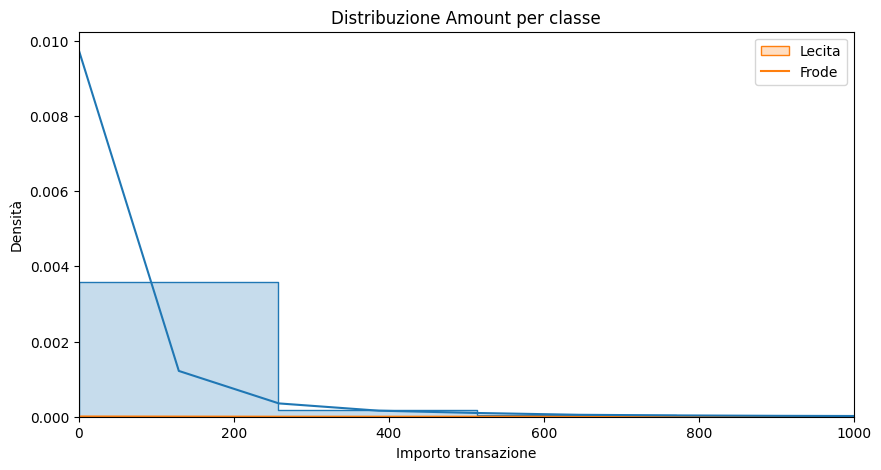

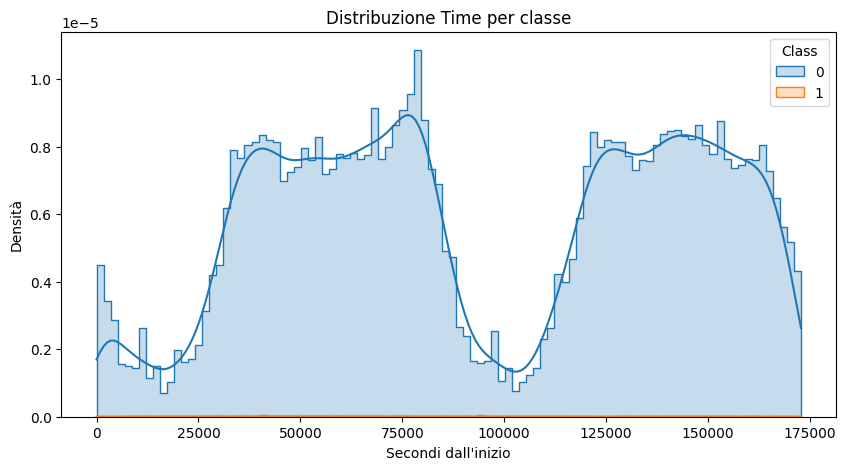

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribuzione Amount per classe
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='Amount', bins=100, hue='Class', kde=True, element="step", stat='density')
plt.title("Distribuzione Amount per classe")
plt.xlabel("Importo transazione")
plt.ylabel("Densit√†")
plt.xlim(0, 1000)  # Rimuove outlier estremi per visualizzare meglio
plt.legend(['Lecita', 'Frode'])
plt.show()

# Distribuzione Time per classe
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='Time', bins=100, hue='Class', kde=True, element="step", stat='density')
plt.title("Distribuzione Time per classe")
plt.xlabel("Secondi dall'inizio")
plt.ylabel("Densit√†")
plt.show()


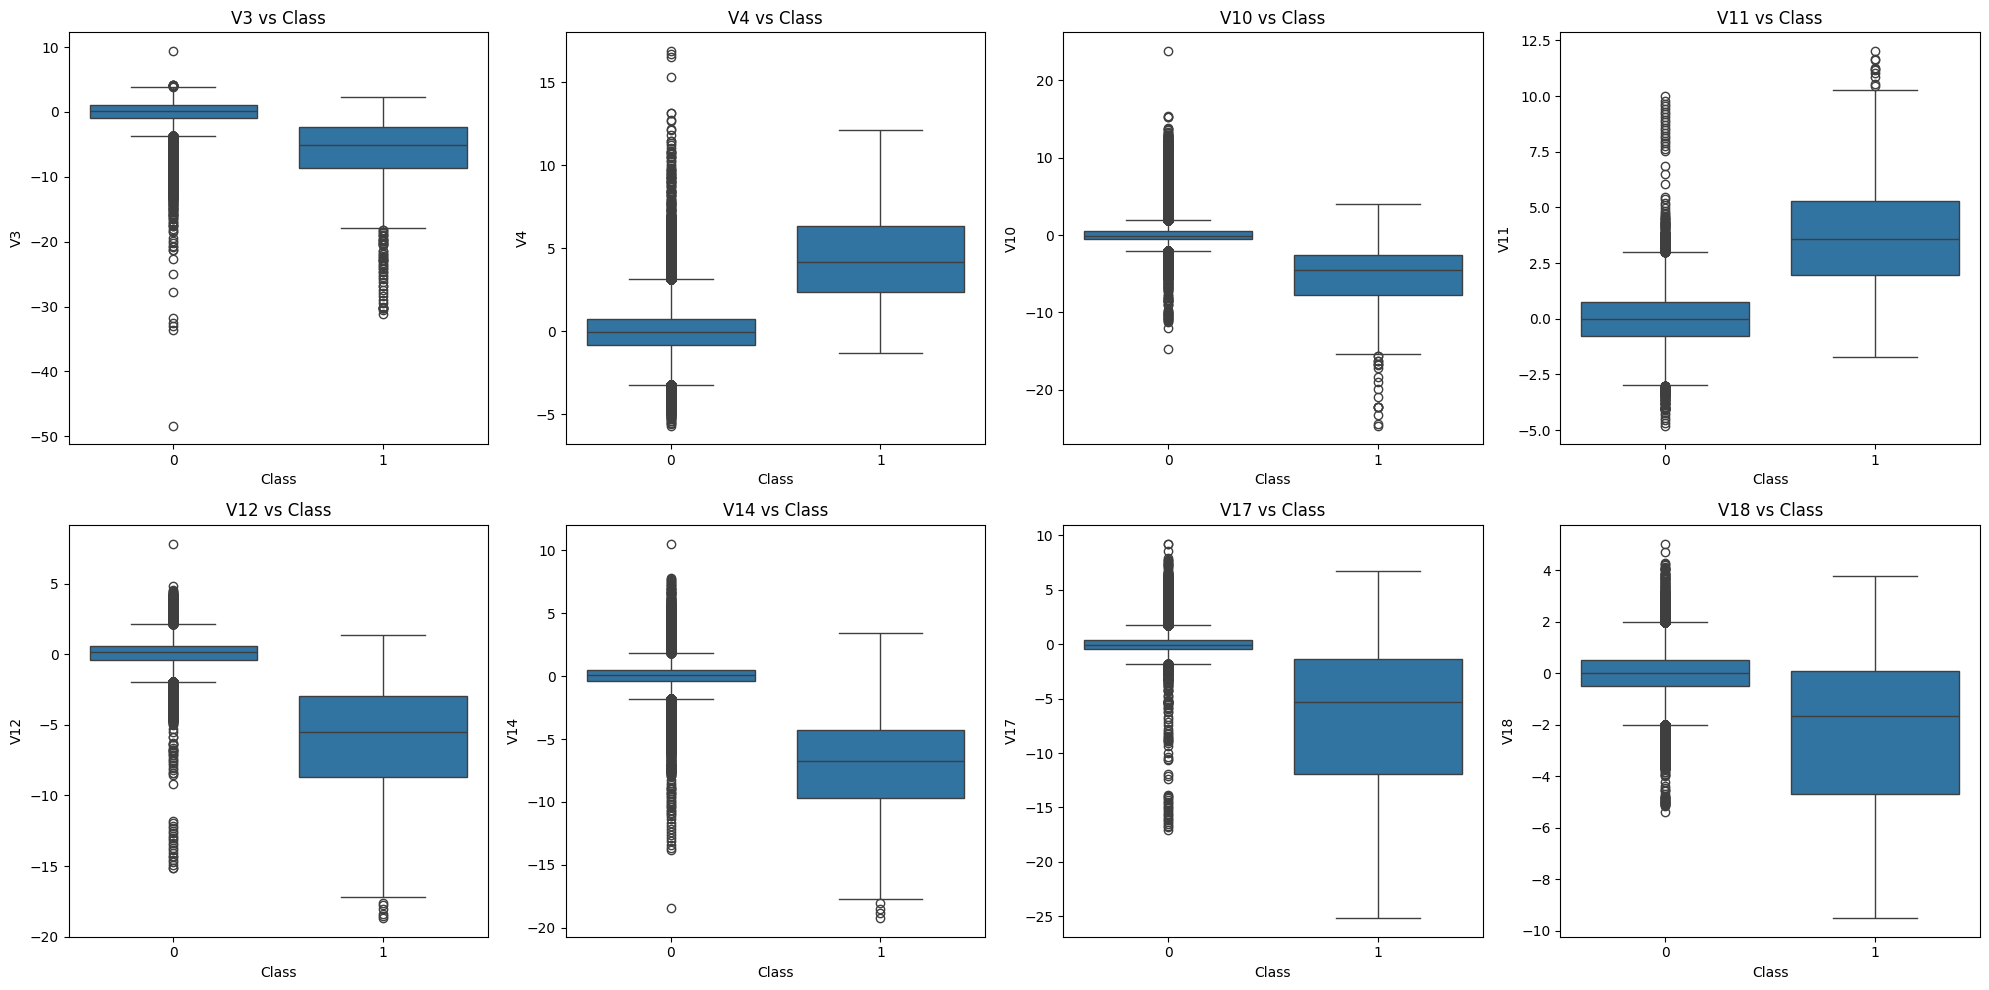

In [3]:
# Boxplot per feature selezionate
features_boxplot = ['V3', 'V4', 'V10', 'V11', 'V12', 'V14', 'V17', 'V18']

plt.figure(figsize=(20, 10))
for i, feature in enumerate(features_boxplot):
    plt.subplot(2, 4, i + 1)
    sns.boxplot(data=df, x='Class', y=feature)
    plt.title(f'{feature} vs Class')
plt.tight_layout()
plt.show()


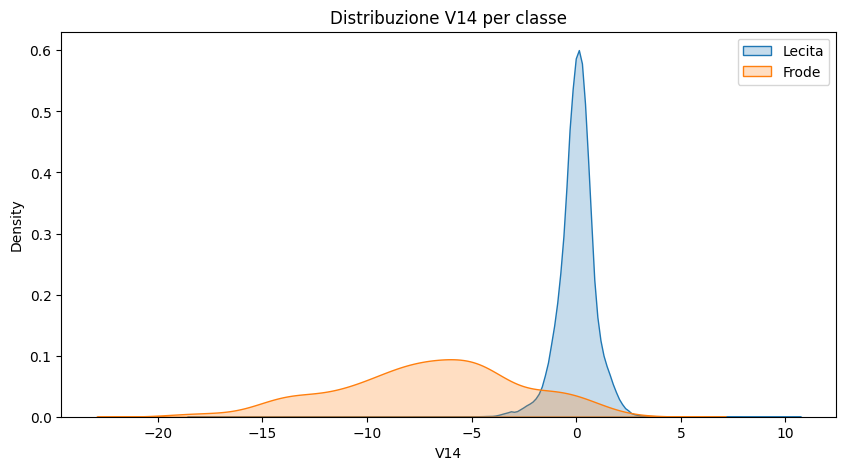

In [4]:
# Esempio: V14, che di solito ha una forte correlazione negativa con frode
plt.figure(figsize=(10, 5))
sns.kdeplot(df[df.Class == 0]['V14'], label='Lecita', fill=True)
sns.kdeplot(df[df.Class == 1]['V14'], label='Frode', fill=True)
plt.title('Distribuzione V14 per classe')
plt.legend()
plt.show()


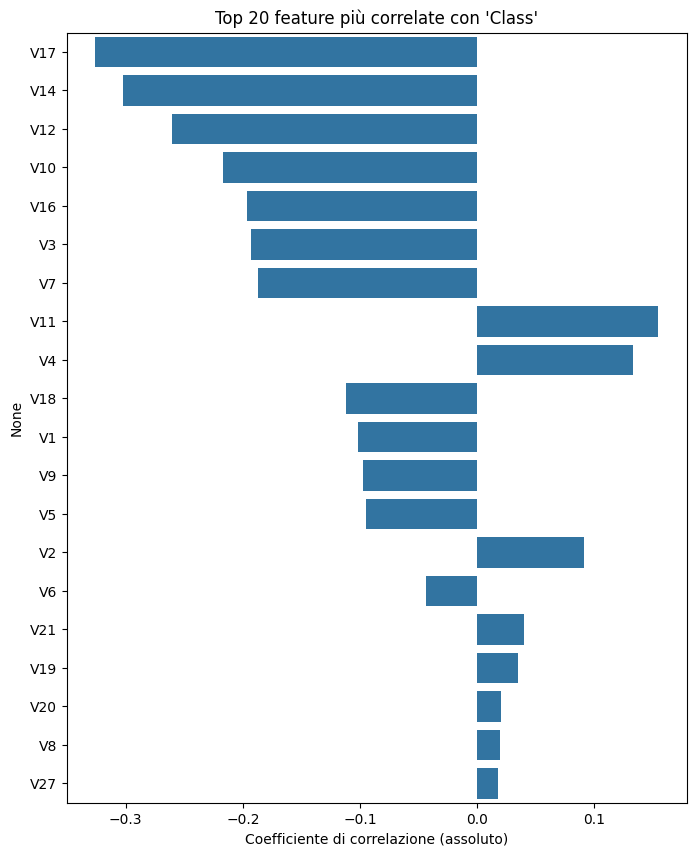

In [5]:
# Correlazioni ordinate con 'Class'
corr_matrix = df.corr()
corr_class = corr_matrix['Class'].sort_values(key=abs, ascending=False)

plt.figure(figsize=(8, 10))
sns.barplot(x=corr_class[1:21].values, y=corr_class[1:21].index)
plt.title("Top 20 feature pi√π correlate con 'Class'")
plt.xlabel("Coefficiente di correlazione (assoluto)")
plt.show()


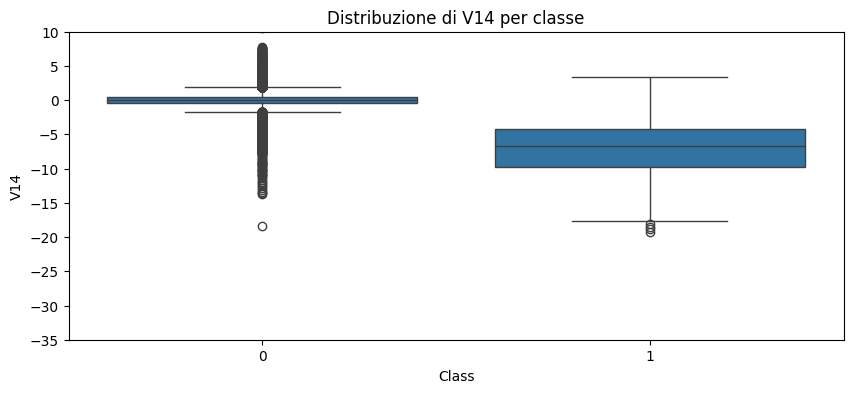

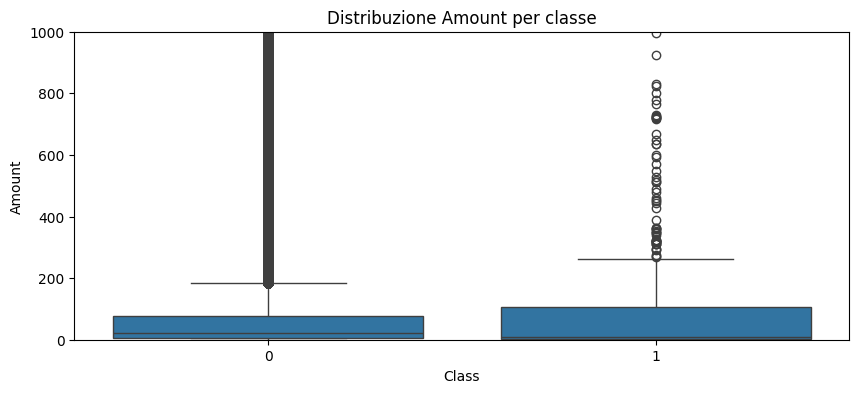

In [6]:
# Boxplot di V14 con zoom
plt.figure(figsize=(10, 4))
sns.boxplot(data=df, x='Class', y='V14')
plt.title("Distribuzione di V14 per classe")
plt.ylim(-35, 10)  # Zoom su outlier
plt.show()

# Boxplot Amount
plt.figure(figsize=(10, 4))
sns.boxplot(data=df, x='Class', y='Amount')
plt.title("Distribuzione Amount per classe")
plt.ylim(0, 1000)  # Zoom per evitare distorsioni
plt.show()


In [7]:
# Identifica outlier estremi di V14
df_sorted = df.sort_values(by='V14')
print("\nTransazioni con valori estremamente negativi di V14:")
display(df_sorted[['V14', 'Class']].head(10))

# Transazioni con importi maggiori
print("\nTransazioni con importi maggiori:")
display(df.sort_values(by='Amount', ascending=False)[['Amount', 'Class']].head(10))



Transazioni con valori estremamente negativi di V14:


V14  Class
8296   -19.214325      1
8615   -18.822087      1
9035   -18.493773      1
118764 -18.392091      0
9252   -18.049998      1
9487   -17.721638      1
41943  -17.620634      1
9509   -17.475921      1
10568  -17.230202      1
42590  -16.337596      1


Transazioni con importi maggiori:


Amount  Class
274771  25691.16      0
58465   19656.53      0
151296  18910.00      0
46841   12910.93      0
54018   11898.09      0
169457  11789.84      0
284249  10199.44      0
227921  10000.00      0
74699    8790.26      0
245474   8787.00      0

<Figure size 1200x500 with 0 Axes>

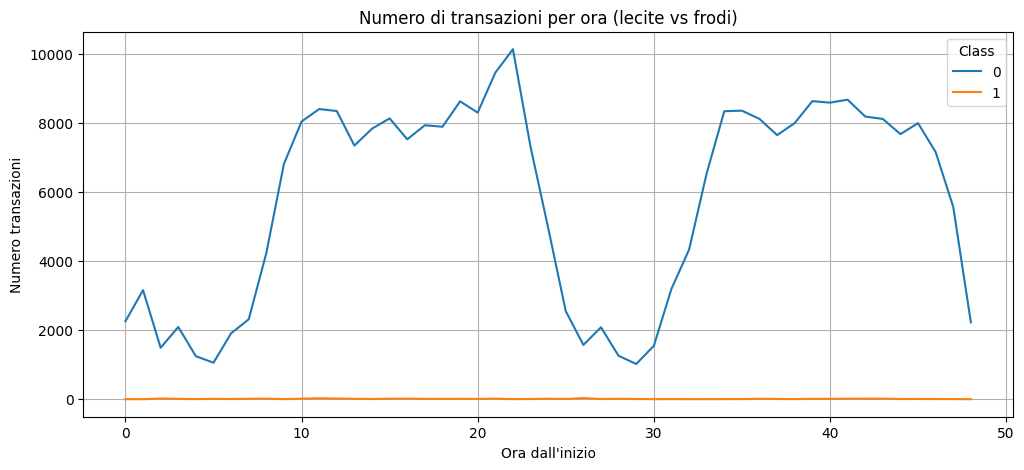

In [8]:
# Crea una nuova colonna con tempo in ore
df['Hour'] = (df['Time'] / 3600).round().astype(int)

# Conta transazioni per ora
tx_per_hour = df.groupby(['Hour', 'Class']).size().unstack(fill_value=0)

# Line plot
plt.figure(figsize=(12, 5))
tx_per_hour.plot(kind='line', figsize=(12,5))
plt.title("Numero di transazioni per ora (lecite vs frodi)")
plt.xlabel("Ora dall'inizio")
plt.ylabel("Numero transazioni")
plt.grid(True)
plt.show()


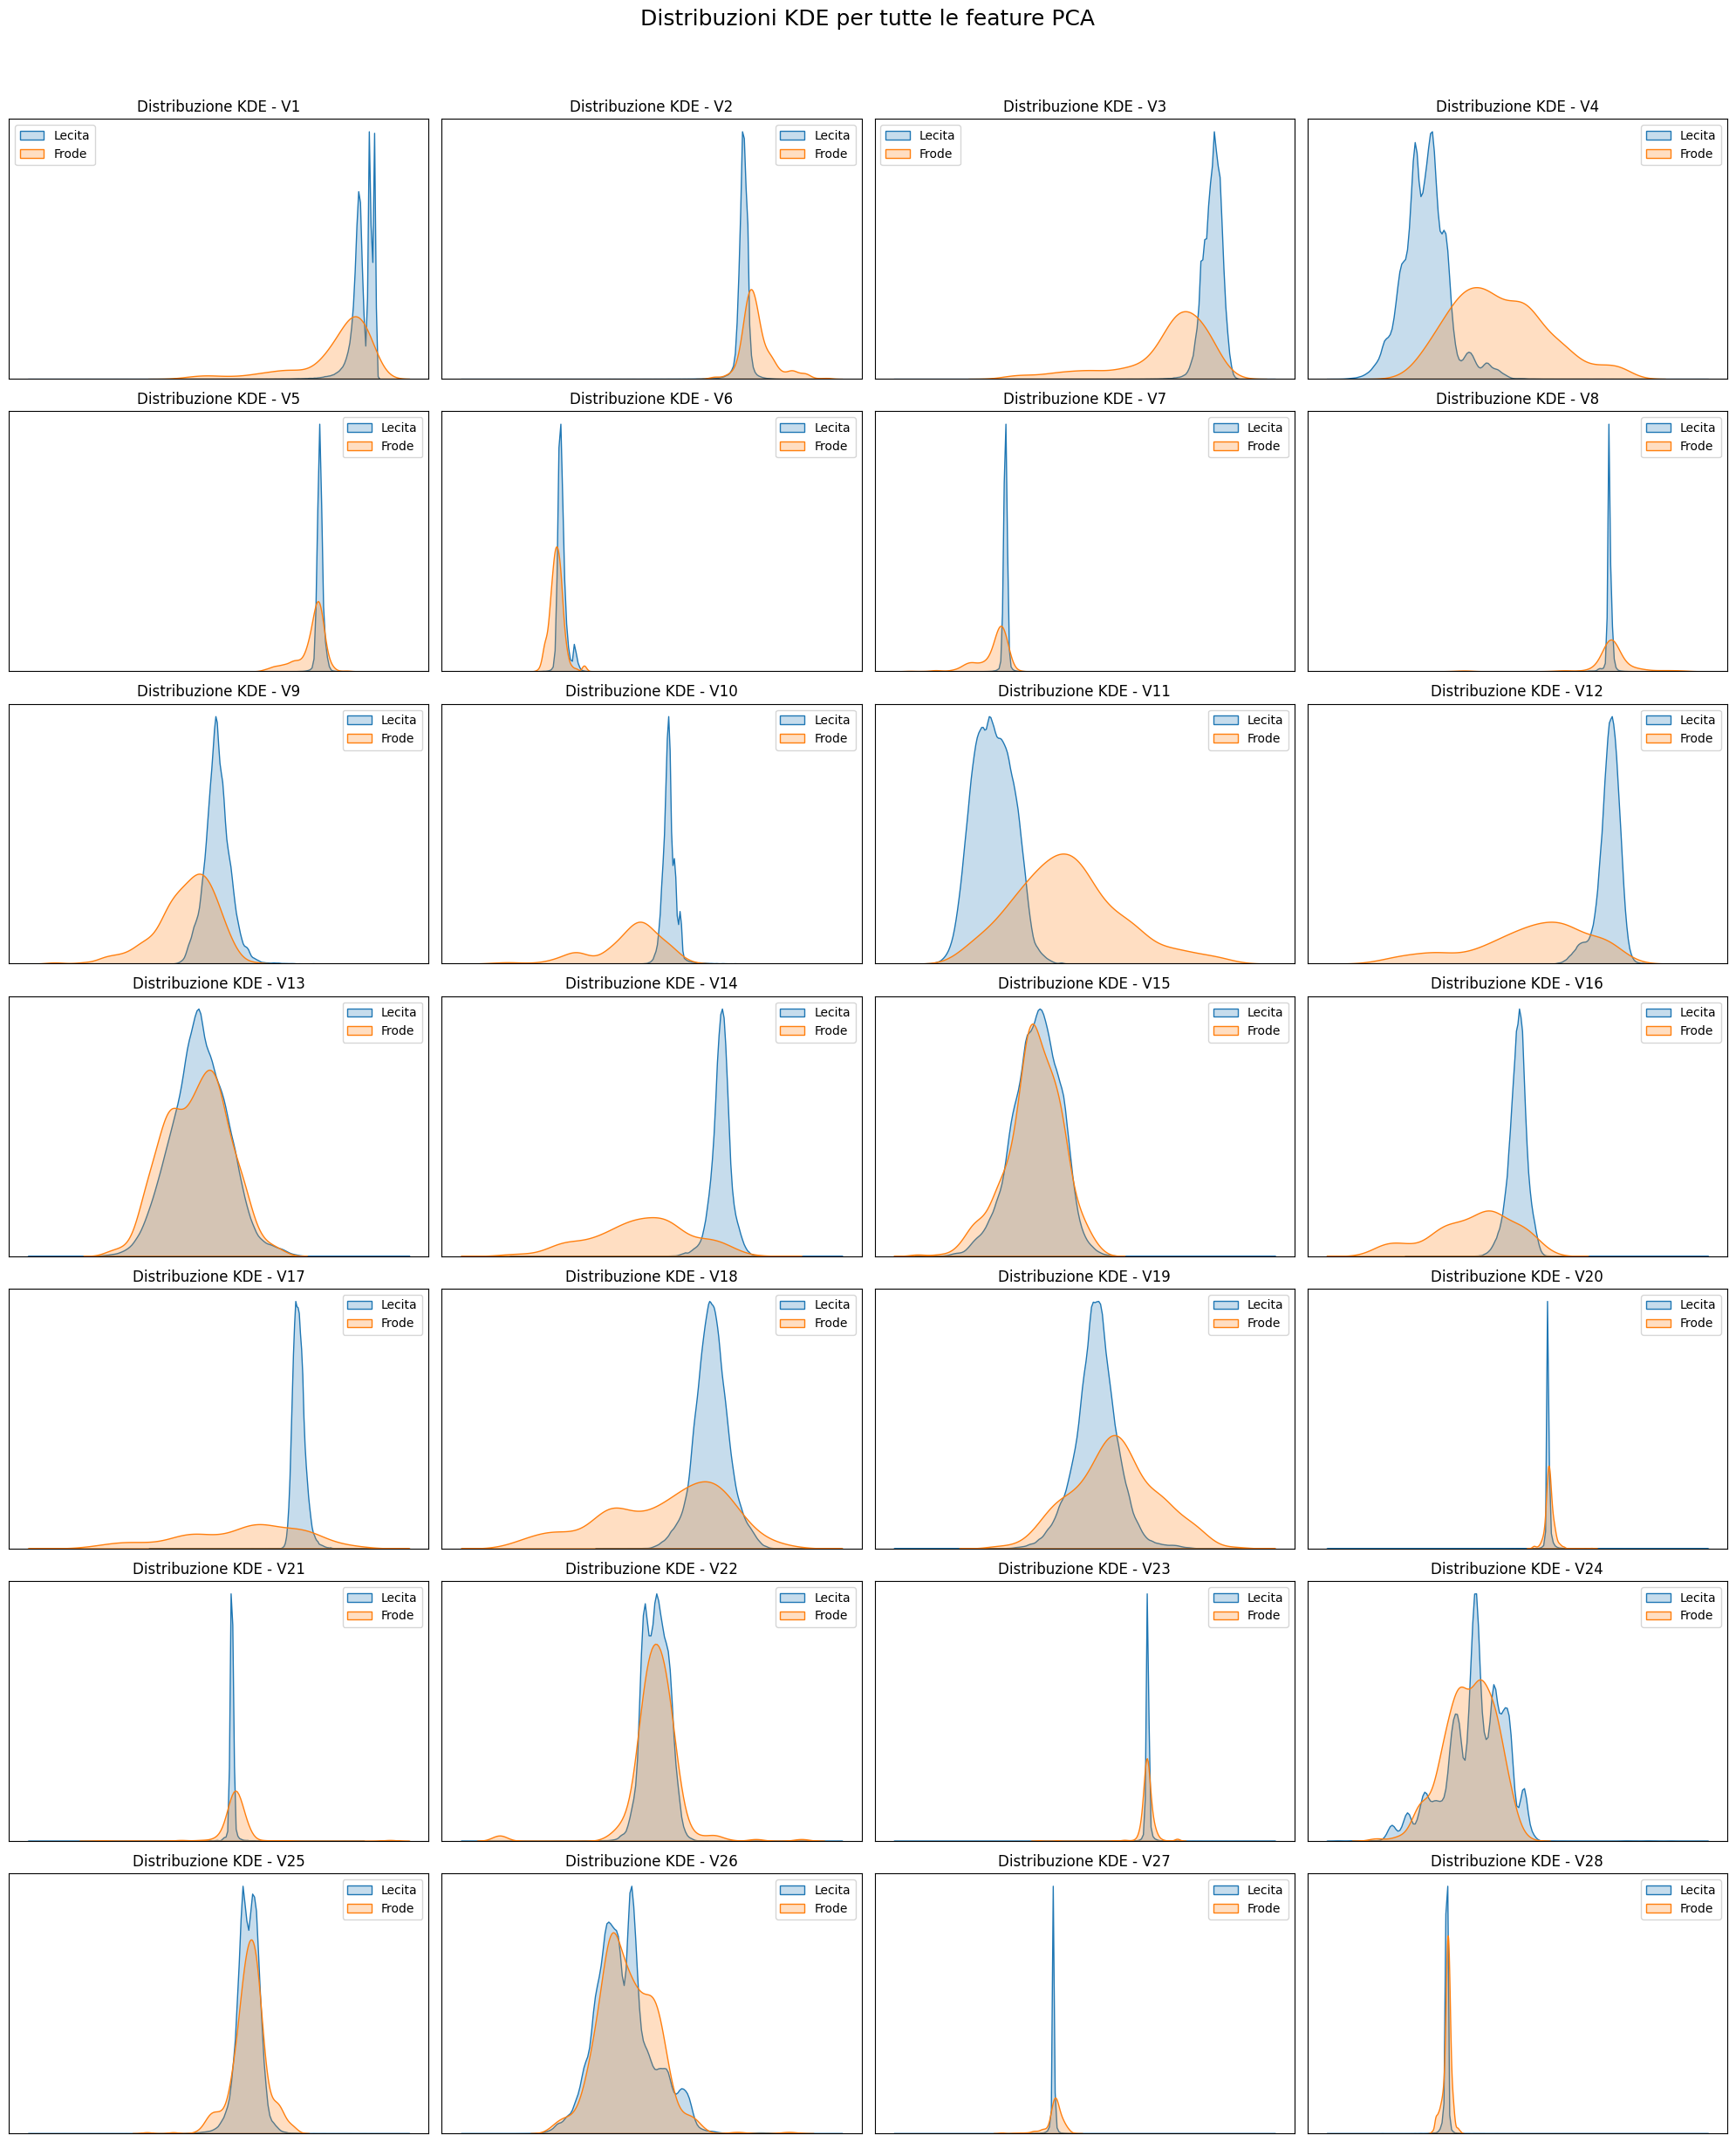

In [9]:
import numpy as np

features = [f'V{i}' for i in range(1, 29)]  # da V1 a V28
rows, cols = 7, 4
plt.figure(figsize=(20, 25))

for i, col in enumerate(features):
    plt.subplot(rows, cols, i + 1)
    sns.kdeplot(df[df.Class == 0][col], label="Lecita", fill=True)
    sns.kdeplot(df[df.Class == 1][col], label="Frode", fill=True)
    plt.title(f'Distribuzione KDE - {col}')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('')
    plt.ylabel('')
    plt.legend()

plt.suptitle("Distribuzioni KDE per tutte le feature PCA", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


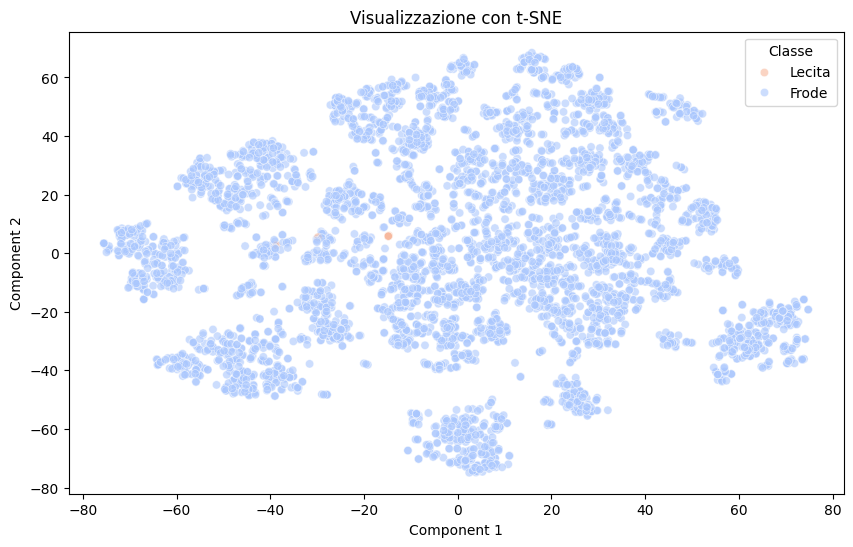

In [10]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Standardizziamo prima i dati
X = df.drop(['Class', 'Hour'], axis=1)  # escludiamo target e colonna derivata
y = df['Class']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Campioniamo (t-SNE √® lento)
df_sample = df.sample(n=5000, random_state=42)
X_sample = scaler.transform(df_sample.drop(['Class', 'Hour'], axis=1))
y_sample = df_sample['Class']

# Applichiamo t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_embedded = tsne.fit_transform(X_sample)

# Visualizzazione
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y_sample, palette='coolwarm', alpha=0.6)
plt.title("Visualizzazione con t-SNE")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Classe", labels=["Lecita", "Frode"])
plt.show()


# PREPROCESSING

1 SELEZIONE E SCALING DELLE FEATURE

In [11]:
from sklearn.preprocessing import StandardScaler

# Copia dei dati per sicurezza
df_prep = df.copy()

# Standardizziamo 'Amount' e 'Time'
scaler = StandardScaler()
df_prep[['Amount', 'Time']] = scaler.fit_transform(df_prep[['Amount', 'Time']])

# Definizione X e y
X = df_prep.drop(['Class', 'Hour'], axis=1)  # Escludiamo target e colonna derivata
y = df_prep['Class']


Step 2: Train/Test Split con stratificazione

In [12]:
from sklearn.model_selection import train_test_split

# Split: 70% training, 30% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

print("Distribuzione classi nel train set:")
print(y_train.value_counts(normalize=True))
print("\nDistribuzione classi nel test set:")
print(y_test.value_counts(normalize=True))


Distribuzione classi nel train set:
Class
0    0.998275
1    0.001725
Name: proportion, dtype: float64

Distribuzione classi nel test set:
Class
0    0.998268
1    0.001732
Name: proportion, dtype: float64


Step 3: Bilanciamento con SMOTE

In [13]:
from imblearn.over_sampling import SMOTE

# Applichiamo SMOTE solo sul training set
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Controlliamo la nuova distribuzione
from collections import Counter
print("Distribuzione dopo SMOTE:")
print(Counter(y_train_res))


Distribuzione dopo SMOTE:
Counter({0: 199020, 1: 199020})


 Salvataggio dei dati preprocessati


In [14]:
import numpy as np

np.savez('/content/drive/MyDrive/FraudDetection/data_balanced.npz',
         X_train=X_train_res, y_train=y_train_res,
         X_test=X_test, y_test=y_test)


In [15]:
# RICARICA DATI SOLO SE NECESSARIO
import numpy as np
data = np.load('/content/drive/MyDrive/FraudDetection/data_balanced.npz')
X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']
y_test = data['y_test']


# **REGRESSIONE LOGISTICA**

In [16]:
from sklearn.linear_model import LogisticRegression

# Inizializzazione del modello
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Addestramento
log_reg.fit(X_train_res, y_train_res)


LogisticRegression(max_iter=1000, random_state=42)

In [17]:
# Predizione delle classi
y_pred = log_reg.predict(X_test)

# Probabilit√† (opzionale, utile per threshold tuning)
y_prob = log_reg.predict_proba(X_test)[:, 1]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


üìÑ Classification Report:
              precision    recall  f1-score   support

           0     0.9998    0.9775    0.9885     85295
           1     0.0634    0.8784    0.1183       148

    accuracy                         0.9773     85443
   macro avg     0.5316    0.9279    0.5534     85443
weighted avg     0.9982    0.9773    0.9870     85443



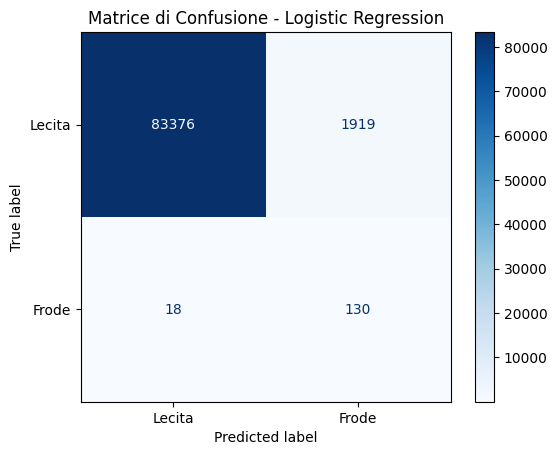

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Report completo
print("üìÑ Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

# Matrice di confusione
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Lecita", "Frode"])
disp.plot(cmap='Blues')
plt.title("Matrice di Confusione - Logistic Regression")
plt.show()


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"üîπ Precision: {precision:.4f}")
print(f"üîπ Recall:    {recall:.4f}")
print(f"üîπ F1-score:  {f1:.4f}")


üîπ Precision: 0.0634
üîπ Recall:    0.8784
üîπ F1-score:  0.1183


In [ ]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, auc

# Probabilit√† classe positiva
y_prob = log_reg.predict_proba(X_test)[:, 1]

# ROC-AUC score
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC: {roc_auc:.4f}")

# PR curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)
print(f"PR-AUC: {pr_auc:.4f}")


ROC-AUC: 0.9660
PR-AUC: 0.7428


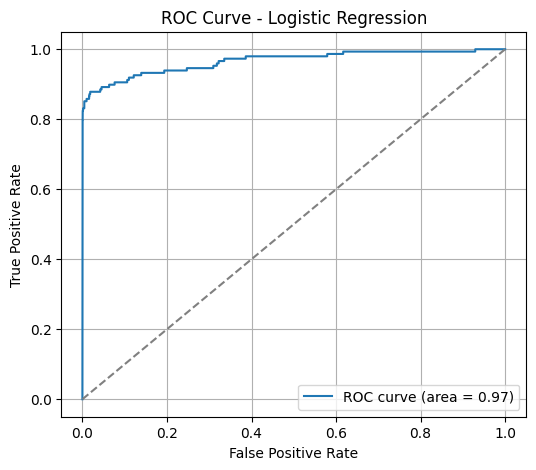

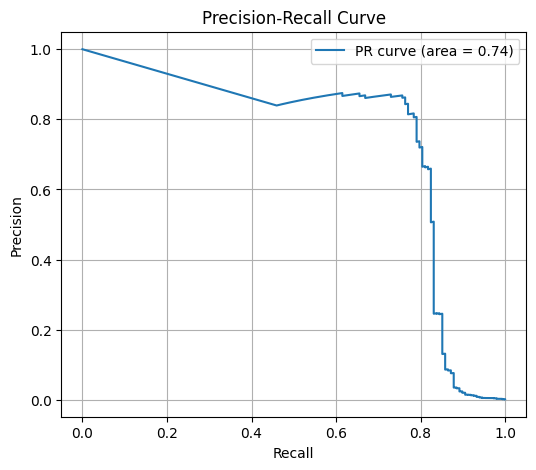

In [ ]:
import matplotlib.pyplot as plt

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend()
plt.grid(True)
plt.show()

# PR curve
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()


# **Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Inizializza la Random Forest
rf = RandomForestClassifier(n_estimators=100,
                            max_depth=None,
                            random_state=42,
                            n_jobs=-1,
                            class_weight=None)  # Non mettiamo 'balanced' perch√© abbiamo usato SMOTE

# Addestramento sul set bilanciato
rf.fit(X_train_res, y_train_res)


RandomForestClassifier(n_jobs=-1, random_state=42)

In [ ]:
# Predizioni di classe
y_pred_rf = rf.predict(X_test)

# Probabilit√† della classe positiva
y_prob_rf = rf.predict_proba(X_test)[:, 1]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


üìÑ Classification Report - Random Forest:
              precision    recall  f1-score   support

           0     0.9996    0.9998    0.9997     85295
           1     0.8667    0.7905    0.8269       148

    accuracy                         0.9994     85443
   macro avg     0.9332    0.8952    0.9133     85443
weighted avg     0.9994    0.9994    0.9994     85443



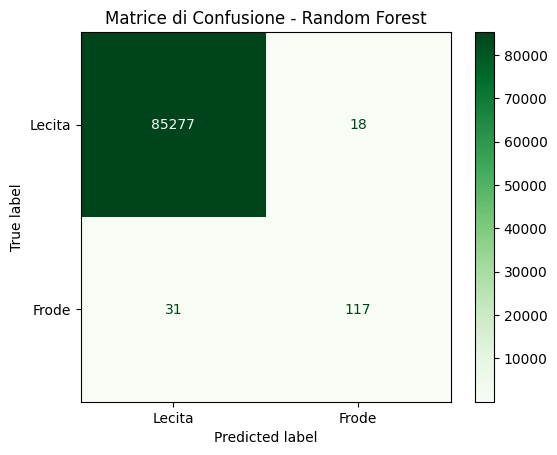

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Report
print("üìÑ Classification Report - Random Forest:")
print(classification_report(y_test, y_pred_rf, digits=4))

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["Lecita", "Frode"])
disp_rf.plot(cmap='Greens')
plt.title("Matrice di Confusione - Random Forest")
plt.show()


In [ ]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, auc

# ROC-AUC
roc_auc_rf = roc_auc_score(y_test, y_prob_rf)
print(f"ROC-AUC: {roc_auc_rf:.4f}")

# PR curve
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_prob_rf)
pr_auc_rf = auc(recall_rf, precision_rf)
print(f"PR-AUC: {pr_auc_rf:.4f}")


ROC-AUC: 0.9544
PR-AUC: 0.8315


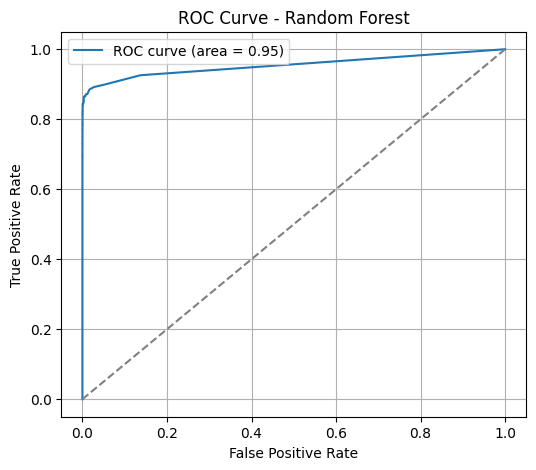

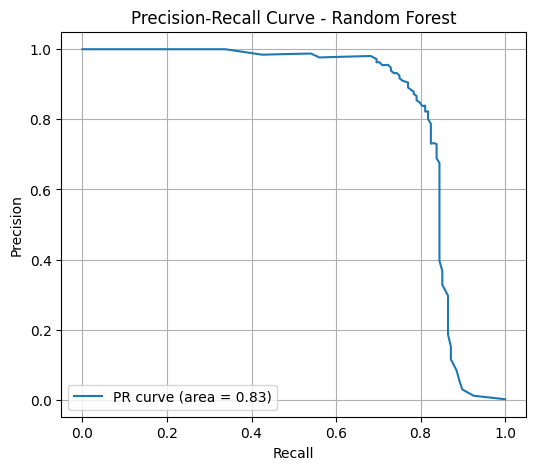

In [ ]:
# ROC curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
plt.figure(figsize=(6, 5))
plt.plot(fpr_rf, tpr_rf, label=f'ROC curve (area = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend()
plt.grid(True)
plt.show()

# Precision-Recall curve
plt.figure(figsize=(6, 5))
plt.plot(recall_rf, precision_rf, label=f'PR curve (area = {pr_auc_rf:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Random Forest')
plt.legend()
plt.grid(True)
plt.show()


# **tuning di iperparametri con randomized search**

Parametri da ottimizzare:
n_estimators: numero di alberi nella foresta

* **max_depth**: profondit√† massima degli alberi

* **min_samples_split**: numero minimo di campioni per dividere un nodo

* **min_samples_leaf**: minimo di campioni per foglia

* **max_features**: numero massimo di feature considerate a ogni split


Strategie applicate:
* Dataset ridotto (15.000 campioni)

* n_iter=10 ‚Üí 10 combinazioni casuali

* cv=2 ‚Üí 2 fold cross-validation

* n_jobs=-1 ‚Üí usa tutti i core disponibili

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import resample
from scipy.stats import randint
import numpy as np

# 1. Campiona un subset del training set bilanciato
X_train_sample, y_train_sample = resample(
    X_train_res, y_train_res,
    replace=False,
    n_samples=15000,
    random_state=42
)

# 2. Definisci i parametri da testare (spazio di ricerca)
param_dist = {
    'n_estimators': randint(50, 150),
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt']
}

# 3. Inizializza il modello base
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# 4. Randomized Search CV veloce
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=10,           # solo 10 combinazioni
    cv=2,                # 2-fold cross-validation
    scoring='f1',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# 5. Esegui la ricerca
random_search.fit(X_train_sample, y_train_sample)

# 6. Stampa i migliori parametri trovati
print("‚úÖ Migliori parametri trovati:")
print(random_search.best_params_)


Fitting 2 folds for each of 10 candidates, totalling 20 fits
‚úÖ Migliori parametri trovati:
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 136}


In [19]:
best_rf = random_search.best_estimator_

# Predizione su X_test
y_pred_rf = best_rf.predict(X_test)
y_prob_rf = best_rf.predict_proba(X_test)[:, 1]

# Valutazione
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc

print(classification_report(y_test, y_pred_rf, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))

precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_prob_rf)
print("PR-AUC:", auc(recall_rf, precision_rf))


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           0     0.9997    0.9975    0.9986     85295
           1     0.3655    0.8446    0.5102       148

    accuracy                         0.9972     85443
   macro avg     0.6826    0.9210    0.7544     85443
weighted avg     0.9986    0.9972    0.9977     85443

ROC-AUC: 0.9742971531235791
PR-AUC: 0.7556309593054504


# **XGBoost**

In [20]:
!pip install xgboost


In [21]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc


# **Addestramento modello**

In [22]:
# Inizializza il classificatore XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

# Addestramento sul set bilanciato
xgb_model.fit(X_train_res, y_train_res)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=-1, num_parallel_tree=None, random_state=42, ...)

# **predizione e valutazione**

üìÑ Classification Report - XGBoost
              precision    recall  f1-score   support

           0     0.9997    0.9978    0.9988     85295
           1     0.4013    0.8378    0.5427       148

    accuracy                         0.9976     85443
   macro avg     0.7005    0.9178    0.7707     85443
weighted avg     0.9987    0.9976    0.9980     85443



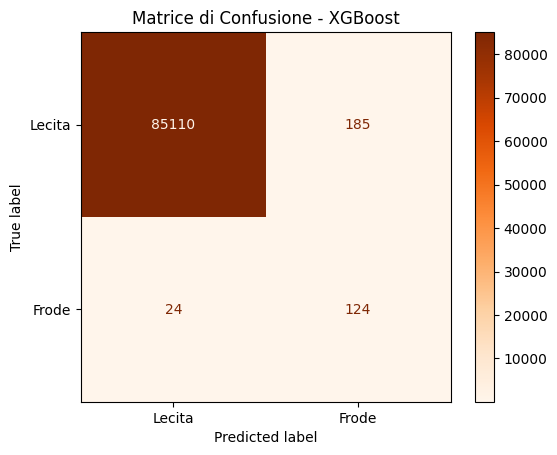

ROC-AUC: 0.9710
PR-AUC:  0.7999


In [23]:
# Predizione
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Classification report
print("üìÑ Classification Report - XGBoost")
print(classification_report(y_test, y_pred_xgb, digits=4))

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_xgb, display_labels=["Lecita", "Frode"], cmap="Oranges"
)
plt.title("Matrice di Confusione - XGBoost")
plt.show()

# ROC-AUC
roc_auc_xgb = roc_auc_score(y_test, y_prob_xgb)
print(f"ROC-AUC: {roc_auc_xgb:.4f}")

# PR-AUC
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_prob_xgb)
pr_auc_xgb = auc(recall_xgb, precision_xgb)
print(f"PR-AUC:  {pr_auc_xgb:.4f}")


# **curve ROC e precision-recall**

In [25]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt

# Calcolo AUC
roc_auc_xgb = roc_auc_score(y_test, y_prob_xgb)
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_prob_xgb)
pr_auc_xgb = auc(recall_xgb, precision_xgb)

# Stampa valori
print(f"ROC-AUC: {roc_auc_xgb:.4f}")
print(f"PR-AUC:  {pr_auc_xgb:.4f}")


ROC-AUC: 0.9710
PR-AUC:  0.7999


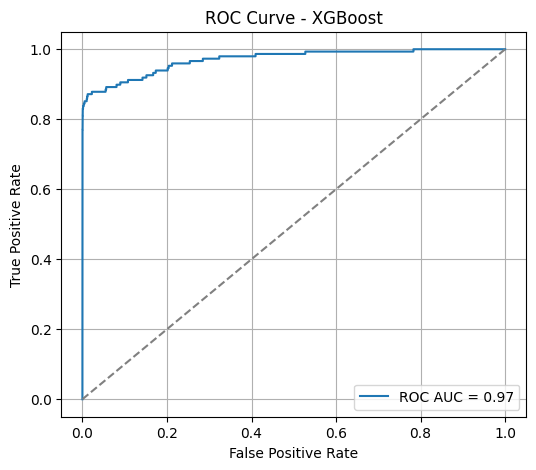

In [26]:
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)

plt.figure(figsize=(6,5))
plt.plot(fpr_xgb, tpr_xgb, label=f'ROC AUC = {roc_auc_xgb:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend()
plt.grid(True)
plt.show()


# **Naive Bayes**

In [27]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Inizializza e allena
nb = GaussianNB()
nb.fit(X_train_res, y_train_res)

# Predizioni
y_pred_nb = nb.predict(X_test)
y_prob_nb = nb.predict_proba(X_test)[:, 1]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


üìÑ Classification Report ‚Äì Naive Bayes
              precision    recall  f1-score   support

           0     0.9997    0.9760    0.9877     85295
           1     0.0567    0.8311    0.1062       148

    accuracy                         0.9758     85443
   macro avg     0.5282    0.9036    0.5470     85443
weighted avg     0.9981    0.9758    0.9862     85443



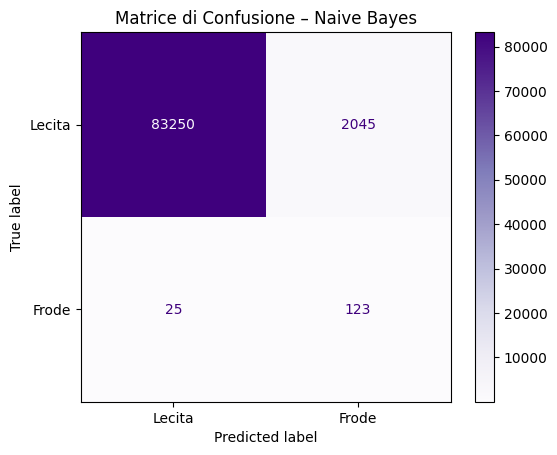

In [28]:
# Classification report
print("üìÑ Classification Report ‚Äì Naive Bayes")
print(classification_report(y_test, y_pred_nb, digits=4))

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_nb, display_labels=["Lecita", "Frode"], cmap="Purples"
)
plt.title("Matrice di Confusione ‚Äì Naive Bayes")
plt.show()


In [29]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, auc

roc_auc_nb = roc_auc_score(y_test, y_prob_nb)
precision_nb, recall_nb, _ = precision_recall_curve(y_test, y_prob_nb)
pr_auc_nb = auc(recall_nb, precision_nb)

print(f"ROC-AUC: {roc_auc_nb:.4f}")
print(f"PR-AUC:  {pr_auc_nb:.4f}")


ROC-AUC: 0.9547
PR-AUC:  0.4208


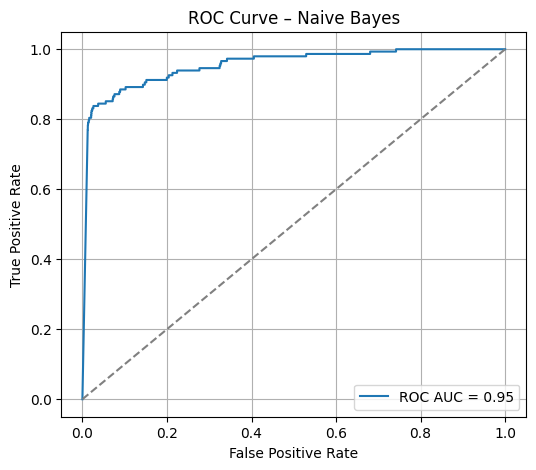

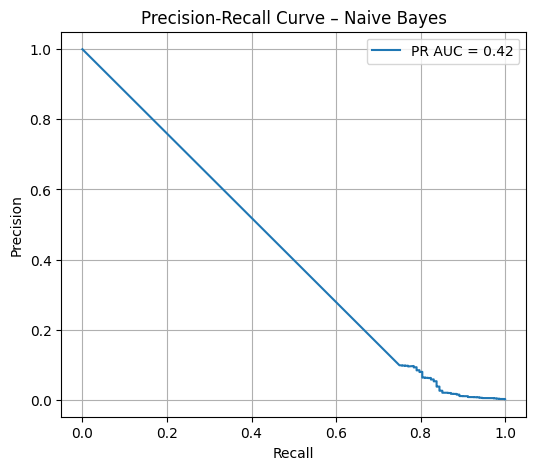

In [30]:
# ROC curve
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_prob_nb)
plt.figure(figsize=(6,5))
plt.plot(fpr_nb, tpr_nb, label=f'ROC AUC = {roc_auc_nb:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve ‚Äì Naive Bayes')
plt.legend()
plt.grid(True)
plt.show()

# PR curve
plt.figure(figsize=(6,5))
plt.plot(recall_nb, precision_nb, label=f'PR AUC = {pr_auc_nb:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve ‚Äì Naive Bayes')
plt.legend()
plt.grid(True)
plt.show()


# **SVM**

# **campionamento del dataset e training svm**

In [31]:
from sklearn.svm import SVC
from sklearn.utils import resample

# Campioniamo 5000‚Äì10000 righe dal set bilanciato
X_train_svm, y_train_svm = resample(
    X_train_res, y_train_res,
    replace=False,
    n_samples=8000,
    random_state=42
)

# Inizializziamo il classificatore SVM (con probabilit√†)
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42)

# Addestramento
svm_model.fit(X_train_svm, y_train_svm)


SVC(probability=True, random_state=42)

# **predizione e valutazione**

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


üìÑ Classification Report ‚Äì SVM
              precision    recall  f1-score   support

           0     0.9997    0.9884    0.9940     85295
           1     0.1129    0.8514    0.1994       148

    accuracy                         0.9882     85443
   macro avg     0.5563    0.9199    0.5967     85443
weighted avg     0.9982    0.9882    0.9927     85443



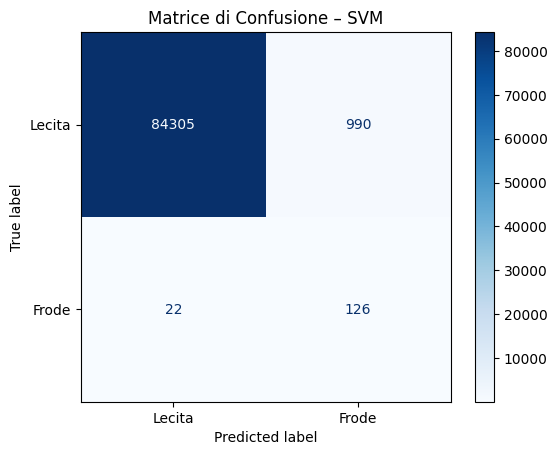

In [32]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Predizione sul test set
y_pred_svm = svm_model.predict(X_test)
y_prob_svm = svm_model.predict_proba(X_test)[:, 1]

# Classification report
print("üìÑ Classification Report ‚Äì SVM")
print(classification_report(y_test, y_pred_svm, digits=4))

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_svm, display_labels=["Lecita", "Frode"], cmap="Blues"
)
plt.title("Matrice di Confusione ‚Äì SVM")
plt.show()


# **roc-auc e pr-auc**

In [33]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, auc

roc_auc_svm = roc_auc_score(y_test, y_prob_svm)
precision_svm, recall_svm, _ = precision_recall_curve(y_test, y_prob_svm)
pr_auc_svm = auc(recall_svm, precision_svm)

print(f"ROC-AUC: {roc_auc_svm:.4f}")
print(f"PR-AUC:  {pr_auc_svm:.4f}")


ROC-AUC: 0.9772
PR-AUC:  0.5997


# **curve roc e pr**

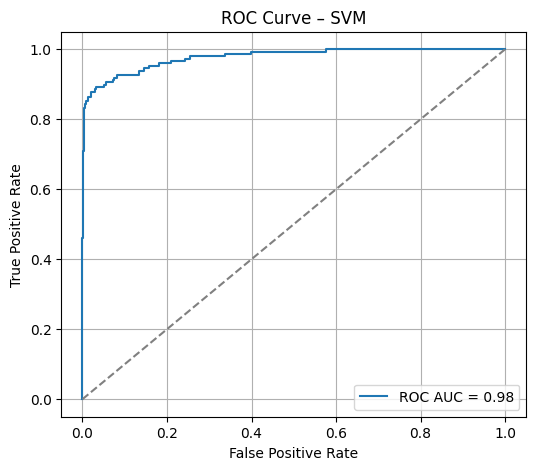

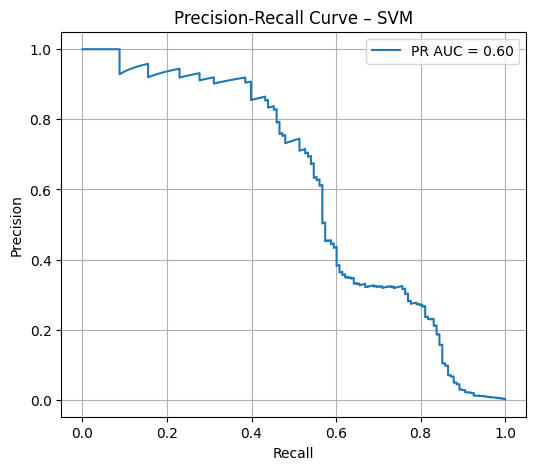

In [34]:
# ROC Curve
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob_svm)
plt.figure(figsize=(6,5))
plt.plot(fpr_svm, tpr_svm, label=f'ROC AUC = {roc_auc_svm:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve ‚Äì SVM')
plt.legend()
plt.grid(True)
plt.show()

# Precision-Recall Curve
plt.figure(figsize=(6,5))
plt.plot(recall_svm, precision_svm, label=f'PR AUC = {pr_auc_svm:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve ‚Äì SVM')
plt.legend()
plt.grid(True)
plt.show()


# **Autoencoder**

Obiettivo:
* Addestrare un Autoencoder solo su transazioni lecite (Class = 0)

* Calcolare l‚Äôerrore di ricostruzione per il test set

* Usare una soglia per classificare le anomalie (frodi)

* Valutare con: classification report, confusion matrix, ROC-AUC, PR-AUC

# **preparazione dei dati**

In [35]:
import numpy as np

# Seleziona solo transazioni lecite per il training
X_train_ae = X_train[y_train == 0]

# Test set completo
X_test_ae = X_test
y_test_ae = y_test


# **costruzione e training dell'autoencoder**

In [36]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Architettura dell'autoencoder
input_dim = X_train_ae.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(16, activation='relu')(input_layer)
encoded = Dense(8, activation='relu')(encoded)
decoded = Dense(16, activation='relu')(encoded)
output_layer = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mse')

# Addestramento
history = autoencoder.fit(
    X_train_ae, X_train_ae,
    epochs=10,
    batch_size=256,
    shuffle=True,
    validation_split=0.1,
    verbose=1
)


Epoch 1/10
700/700 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 13s 11ms/step - loss: 0.9112 - val_loss: 0.5107
Epoch 2/10
700/700 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 12s 3ms/step - loss: 0.4624 - val_loss: 0.3892
Epoch 3/10
700/700 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 5ms/step - loss: 0.3838 - val_loss: 0.3607
Epoch 4/10
700/700 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 2ms/step - loss: 0.3598 - val_loss: 0.3434
Epoch 5/10
700/700 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 3ms/step - loss: 0.3400 - val_loss: 0.3483
Epoch 6/10
700/700 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 3ms/step - loss: 0.3273 - val_loss: 0.3368
Epoch 7/10
700/700 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 2ms/step - loss: 0.3187 - val_loss: 0.3055
Epoch 8/10
700/700 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 2ms/step - loss: 0.3083 - val_lo

# **calcolo errore di ricostruzione**

In [37]:
# Ricostruzione del test set
X_test_pred = autoencoder.predict(X_test_ae)

# Calcolo MSE per ogni riga
mse = np.mean(np.power(X_test_ae - X_test_pred, 2), axis=1)

# Soglia: 95¬∞ percentile
threshold = np.percentile(mse, 95)
print(f"Soglia di errore (95¬∞ percentile): {threshold:.4f}")


2671/2671 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 1ms/step
Soglia di errore (95¬∞ percentile): 0.6627


# **classificazione e valutazione**

üìÑ Classification Report ‚Äì Autoencoder
              precision    recall  f1-score   support

           0     0.9997    0.9514    0.9749     85295
           1     0.0293    0.8446    0.0565       148

    accuracy                         0.9512     85443
   macro avg     0.5145    0.8980    0.5157     85443
weighted avg     0.9980    0.9512    0.9734     85443



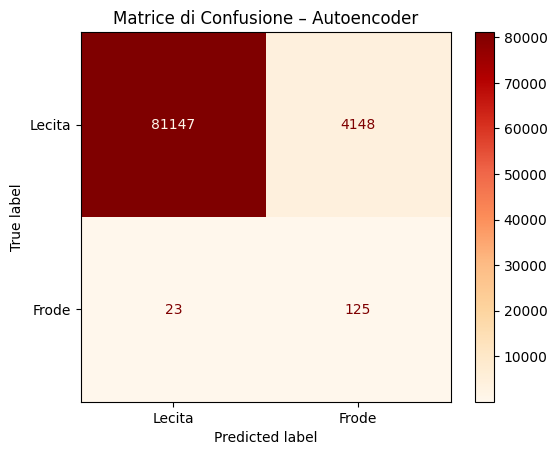

ROC-AUC: 0.9506
PR-AUC:  0.5097


In [38]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, auc

# Classifica: frode se errore > soglia
y_pred_ae = (mse > threshold).astype(int)

# Report e matrice di confusione
print("üìÑ Classification Report ‚Äì Autoencoder")
print(classification_report(y_test_ae, y_pred_ae, digits=4))

ConfusionMatrixDisplay.from_predictions(
    y_test_ae, y_pred_ae, display_labels=["Lecita", "Frode"], cmap="OrRd"
)
plt.title("Matrice di Confusione ‚Äì Autoencoder")
plt.show()

# ROC-AUC & PR-AUC
roc_auc_ae = roc_auc_score(y_test_ae, mse)
precision_ae, recall_ae, _ = precision_recall_curve(y_test_ae, mse)
pr_auc_ae = auc(recall_ae, precision_ae)

print(f"ROC-AUC: {roc_auc_ae:.4f}")
print(f"PR-AUC:  {pr_auc_ae:.4f}")


# **curve ROC e Precision-Recall**

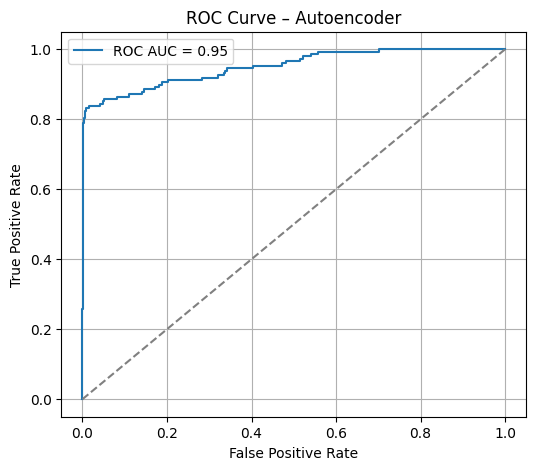

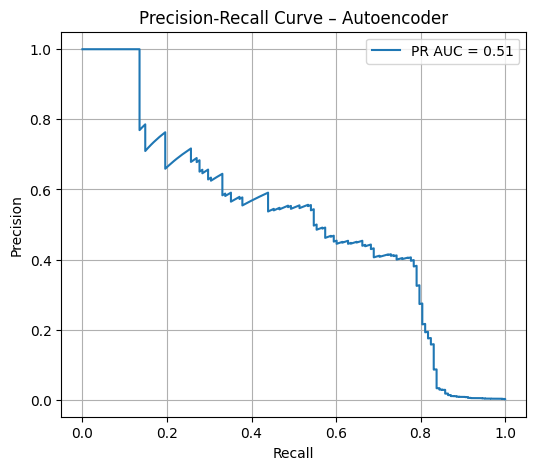

In [39]:
fpr_ae, tpr_ae, _ = roc_curve(y_test_ae, mse)

plt.figure(figsize=(6,5))
plt.plot(fpr_ae, tpr_ae, label=f'ROC AUC = {roc_auc_ae:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve ‚Äì Autoencoder')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(6,5))
plt.plot(recall_ae, precision_ae, label=f'PR AUC = {pr_auc_ae:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve ‚Äì Autoencoder')
plt.legend()
plt.grid(True)
plt.show()


# **LSTM**

In [40]:
import numpy as np

# Prepara i dati leciti per il training
X_train_lstm = X_train[y_train == 0]
X_train_lstm = np.reshape(X_train_lstm, (X_train_lstm.shape[0], 1, X_train_lstm.shape[1]))

# Prepara test set (tutte le transazioni)
X_test_lstm = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))


In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense

timesteps = X_train_lstm.shape[1]
features = X_train_lstm.shape[2]

model = Sequential([
    LSTM(32, activation='relu', input_shape=(timesteps, features), return_sequences=False),
    RepeatVector(timesteps),
    LSTM(32, activation='relu', return_sequences=True),
    TimeDistributed(Dense(features))
])

model.compile(optimizer='adam', loss='mse')
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ lstm (LSTM)                     ‚îÇ (None, 32)             ‚îÇ         8,064 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ repeat_vector (RepeatVector)    ‚îÇ (None, 1, 32)          ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm_1 (LSTM)                   ‚îÇ (None, 1, 32)          ‚îÇ         8,320 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ time_distributed                ‚îÇ (None, 1, 30)          ‚îÇ           990 ‚îÇ
‚îÇ (TimeDistributed)               ‚îÇ                        ‚îÇ               ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 17,374 (67.87 KB)

 Trainable params: 17,374 (67.87 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
history = model.fit(
    X_train_lstm, X_train_lstm,
    epochs=10,
    batch_size=256,
    validation_split=0.1,
    shuffle=True,
    verbose=1
)


Epoch 1/10
700/700 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 6ms/step - loss: 0.6628 - val_loss: 0.1134
Epoch 2/10
700/700 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 2ms/step - loss: 0.0883 - val_loss: 0.0375
Epoch 3/10
700/700 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 2ms/step - loss: 0.0281 - val_loss: 0.0146
Epoch 4/10
700/700 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 3ms/step - loss: 0.0129 - val_loss: 0.0074
Epoch 5/10
700/700 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 3ms/step - loss: 0.0066 - val_loss: 0.0047
Epoch 6/10
700/700 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 3ms/step - loss: 0.0039 - val_loss: 0.0043
Epoch 7/10
700/700 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 2ms/step - loss: 0.0030 - val_loss: 0.0023
Epoch 8/10
700/700 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 5ms/step - loss: 0.0018 - val_loss:

In [43]:
# Ricostruzione del test set
X_test_pred_lstm = model.predict(X_test_lstm)

# Calcolo errore di ricostruzione
mse_lstm = np.mean(np.power(X_test_lstm - X_test_pred_lstm, 2), axis=(1,2))

# Soglia dinamica (95¬∞ percentile)
threshold_lstm = np.percentile(mse_lstm, 95)
print(f"Soglia di errore (95¬∞ percentile): {threshold_lstm:.4f}")


2671/2671 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 2ms/step
Soglia di errore (95¬∞ percentile): 0.0018


üìÑ Classification Report ‚Äì LSTM Autoencoder
              precision    recall  f1-score   support

           0     0.9997    0.9513    0.9749     85295
           1     0.0288    0.8311    0.0556       148

    accuracy                         0.9511     85443
   macro avg     0.5142    0.8912    0.5153     85443
weighted avg     0.9980    0.9511    0.9733     85443



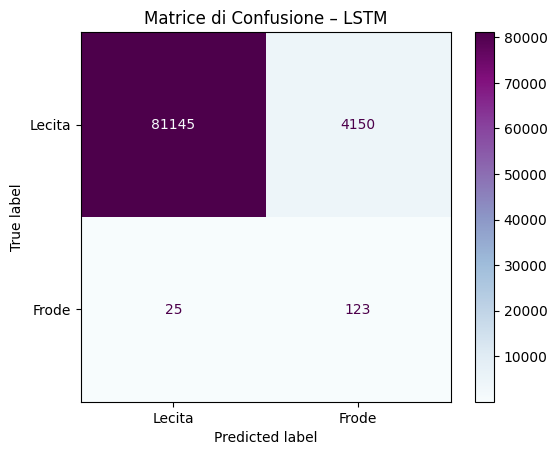

ROC-AUC: 0.9591
PR-AUC:  0.7097


In [44]:
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, roc_curve, auc, ConfusionMatrixDisplay

# Classificazione
y_pred_lstm = (mse_lstm > threshold_lstm).astype(int)

# Report
print("üìÑ Classification Report ‚Äì LSTM Autoencoder")
print(classification_report(y_test, y_pred_lstm, digits=4))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_lstm, display_labels=["Lecita", "Frode"], cmap="BuPu"
)
plt.title("Matrice di Confusione ‚Äì LSTM")
plt.show()

# ROC e PR AUC
roc_auc_lstm = roc_auc_score(y_test, mse_lstm)
precision_lstm, recall_lstm, _ = precision_recall_curve(y_test, mse_lstm)
pr_auc_lstm = auc(recall_lstm, precision_lstm)

print(f"ROC-AUC: {roc_auc_lstm:.4f}")
print(f"PR-AUC:  {pr_auc_lstm:.4f}")


# **GRAFICI CONFRONTO**

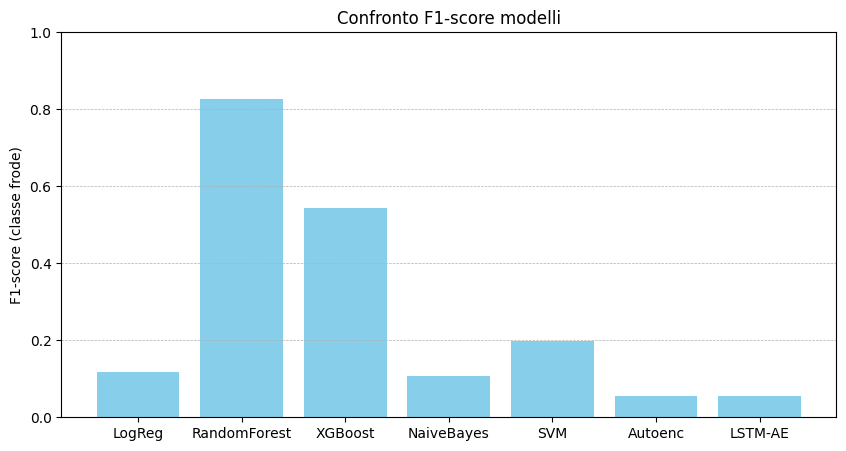

In [1]:
import matplotlib.pyplot as plt

models = ["LogReg", "RandomForest", "XGBoost", "NaiveBayes", "SVM", "Autoenc", "LSTM-AE"]
f1_scores = [0.1183, 0.8269, 0.5427, 0.1062, 0.1994, 0.0565, 0.0556]

plt.figure(figsize=(10, 5))
plt.bar(models, f1_scores, color='skyblue')
plt.ylim(0, 1)
plt.title("Confronto F1-score modelli")
plt.ylabel("F1-score (classe frode)")
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.show()


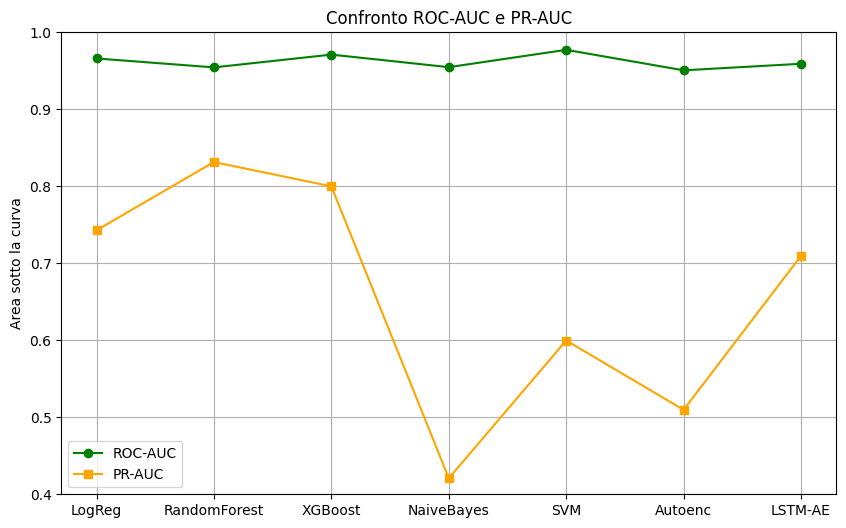

In [2]:
# Valori da tabella
roc_auc = [0.9660, 0.9544, 0.9710, 0.9547, 0.9772, 0.9506, 0.9591]
pr_auc = [0.7428, 0.8315, 0.7999, 0.4208, 0.5997, 0.5097, 0.7097]

x = range(len(models))

plt.figure(figsize=(10,6))
plt.plot(x, roc_auc, marker='o', label='ROC-AUC', color='green')
plt.plot(x, pr_auc, marker='s', label='PR-AUC', color='orange')
plt.xticks(x, models)
plt.ylim(0.4, 1.0)
plt.title("Confronto ROC-AUC e PR-AUC")
plt.ylabel("Area sotto la curva")
plt.legend()
plt.grid(True)
plt.show()
